## 1. Загрузка и обработка данных

### 1.1 Наличие пропусков и дубликатов

In [1]:
import pandas as pd
# Загрузка данных
ds_salaries = pd.read_csv('data/ds_salaries.csv')
# Создание копии
data = ds_salaries.copy()
# Отображение характеристик датасета
display(data.info())
# Начилие пропусков в каждом столбце
print('\nНачилие пропусков в каждом столбце\n', data.isnull().sum().to_frame())
# Наличие дубликатов в каждом столбце
print('\nНаличие дубликатов\n', data[data.duplicated()].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None


Начилие пропусков в каждом столбце
                     0
Unnamed: 0          0
work_year           0
experience_level    0
employment_type     0
job_title           0
salary              0
salary_currency     0
salary_in_usd       0
employee_residence  0
remote_ratio        0
company_location    0
company_size        0

Наличие дубликатов
 0


Датасет не имеет пропусков или дубликатов. Дополнительное исследование на значение, которым можно заменить пропуск, или возможность удаления пропусков по осями или дубликатов, проводить не нужно

### 1.2 Определение неинформативных признаков

Неинформативные признаки - признаки, имеющие сильную корреляцию\
Для выявления используется метод Кендалла, так как он устойчив к выбросам

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
Unnamed: 0,1.000000,0.764612,0.068628,0.166970,0.103185
work_year,0.764612,1.000000,0.077898,0.214867,0.115797
salary,0.068628,0.077898,1.000000,0.695795,0.088432
salary_in_usd,0.166970,0.214867,0.695795,1.000000,0.141753
remote_ratio,0.103185,0.115797,0.088432,0.141753,1.000000


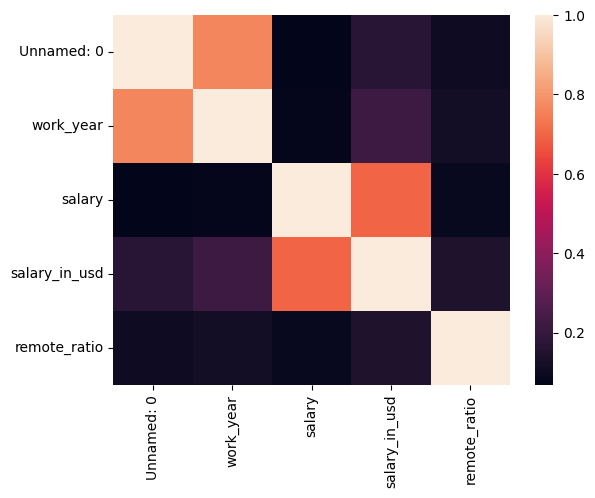

In [2]:
import seaborn as sns
# Построение корреляционной матрицы для выявления взавимозависимости
correlation = data.corr(method='kendall',numeric_only=True)
# Вывод коэффициентов корреляции
display(correlation)
# Тепловая карта корреляции
sns.heatmap(data.corr(method='kendall',numeric_only=True));

Исходя из тепловой карты, значения для признака Unnamed:0 обладают сильной корреляцией с коэффициентом > 0.7, поэтому этот признак следует удалить

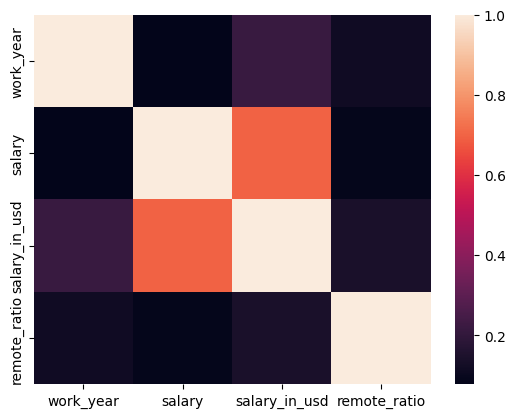

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)
# Тепловая карта корреляции после удаления
sns.heatmap(data.corr(method='kendall',numeric_only=True));

Остальные признаки имеют корреляционные коффициенты < 0.7

### 1.3 Классификация признаков на числовые и категориальные

Числовые признаки имеют много уникальных значений, категориальные обычно < 4. Но основываясь на описании столбцов, данных в модуле, возьмем 5 уникальных значений

In [4]:
# Список для записи категориальных признаков
list_categorial = list()
# Цикл для вывода столбцов категориальных признаков
for column in data.columns:
    if data[column].nunique() < 5:
        list_categorial.append(column)
        print(column, ' ', data[column].nunique())

work_year   3
experience_level   4
employment_type   4
remote_ratio   3
company_size   3


Следовательно все остальные признаки - числовые

Можно преобразовать признаки из текста в числа и вывести уже с учетом этого матрицу корреляций\
Но для начала нужно знать сколько у номинальных призанков уникальных значений -> исходя из этого выбрать тип кодирования

In [5]:
import category_encoders as ce
# Так как уникальных значений немного, выбрано однократное кодирование
encoder = ce.OneHotEncoder(cols=list_categorial, use_cat_names=True)
cols_bin = encoder.fit_transform(data[list_categorial])
data = pd.concat([data, cols_bin], axis=1)
data[list_categorial].head(4)

,work_year,experience_level,employment_type,remote_ratio,company_size
0,2020,MI,FT,0,L
1,2020,SE,FT,0,S
2,2020,SE,FT,50,M
3,2020,MI,FT,0,S


In [6]:
# Цикл для вывода столбцов номинальных признаков
for column in data.columns:
    if data[column].nunique() > 15:
        list_categorial.append(column)
        print(column, ' ', data[column].nunique())

job_title   50
salary   272
salary_currency   17
salary_in_usd   369
employee_residence   57
company_location   50


Итерес представляют employee_residence и company_location. Так как уникальных значений больше 15 - бинарное кодирование

In [7]:
encoder = ce.BinaryEncoder(cols=['employee_residence', 'company_location'])
cols_bin = encoder.fit_transform(data[['employee_residence', 'company_location']])
data = pd.concat([data, cols_bin], axis=1)
data.head(4)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,employee_residence_2,employee_residence_3,employee_residence_4,employee_residence_5,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,...,0,0,0,1,0,0,0,0,0,1
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,...,0,0,1,0,0,0,0,0,1,0
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,...,0,0,1,1,0,0,0,0,1,1
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,...,0,1,0,0,0,0,0,1,0,0


Отображение тепловой карты с учетом преобразования категориальных признаков


<Axes: >

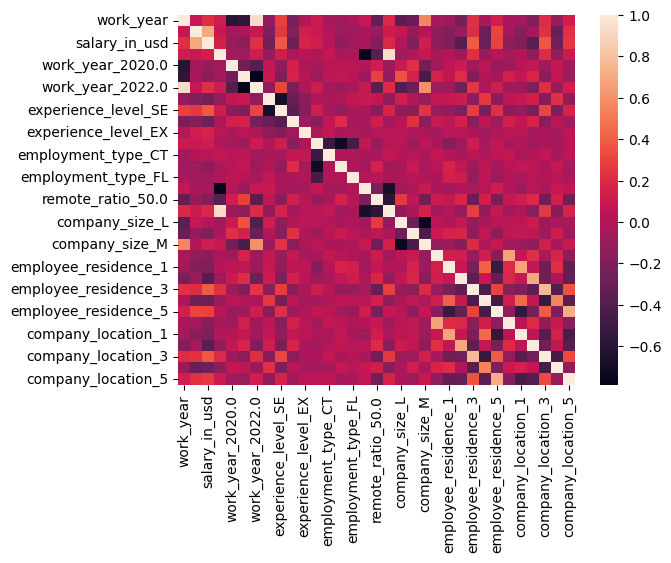

In [8]:
correlation_cat = data.corr(method='kendall',numeric_only=True)
print('Отображение тепловой карты с учетом преобразования категориальных признаков')
display(sns.heatmap(correlation_cat))

Видно, что есть сильная корреляция между категориальными признаками. Их нужно почистить

In [9]:
# За коэффициент сильной корреляции примем 0.7. Сравним признаки
mask = (correlation_cat > 0.7) & (correlation_cat != 1) | (correlation_cat < -0.7)
# Удалим дубликаты и приведем данные в вертикальном формате
print('Наибольшей положительной или отрицательной корреляцией обладают следующие признаки:')
display(correlation_cat[mask].stack().dropna().drop_duplicates())

Наибольшей положительной или отрицательной корреляцией обладают следующие признаки:


work_year             work_year_2022.0      0.924497
remote_ratio          remote_ratio_0.0     -0.785977
                      remote_ratio_100.0    0.934124
work_year_2021.0      work_year_2022.0     -0.782460
employment_type_FT    employment_type_PT   -0.719987
company_size_L        company_size_M       -0.749422
employee_residence_3  company_location_3    0.765408
employee_residence_5  company_location_5    0.708075
dtype: float64

Отображение тепловой карты с учетом преобразования категориальных признаков после удаления сильной корреляции


<Axes: >

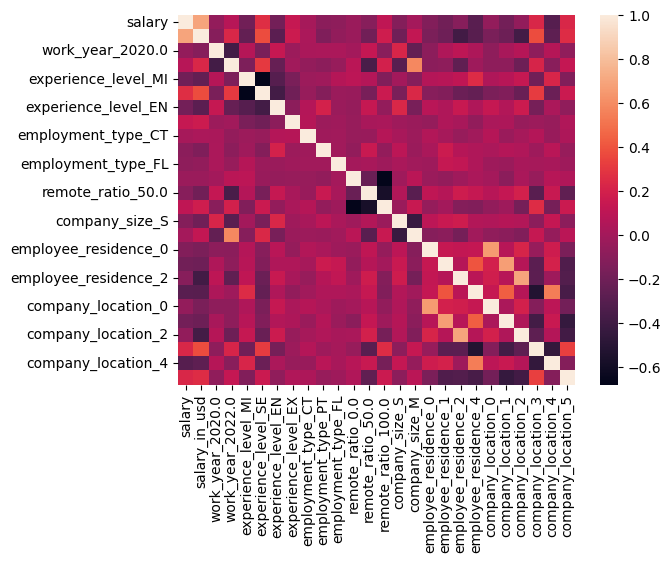

In [10]:
high_corr_columns = ['work_year', 'remote_ratio', 'work_year_2021.0', 'employment_type_FT', 'company_size_L',
                      'employee_residence_3', 'employee_residence_5']
data = data.drop(high_corr_columns, axis=1)
correlation_cat = data.corr(method='kendall',numeric_only=True)
print('Отображение тепловой карты с учетом преобразования категориальных признаков после удаления сильной корреляции')
display(sns.heatmap(correlation_cat))

В данных еще остался тип object. Что из себя представляют эти данные:

In [11]:
# Вывод наименований столбцов списком с типом object
data.select_dtypes(include=['object']).columns.to_list()

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

job_title - признак, по которому будем фильтровать вакансии для Data Scients'ов от остальных\
employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны\
company_location - страна главного офиса работодателя

последние два признака нужно использовать для анализа зависимости зарплаты

### 1.4 Основные статистические характеристики каждого из признаков

In [12]:
print('Основные статистические харакетриктики столбцов')
display(data.describe())
print('Вывод стандартных отклонений')
display(data.describe().loc['std'])

Основные статистические харакетриктики столбцов


,salary,salary_in_usd,work_year_2020.0,work_year_2022.0,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,employment_type_CT,employment_type_PT,...,employee_residence_0,employee_residence_1,employee_residence_2,employee_residence_4,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5
count,6.070000e+02,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.00000,607.000000,607.000000,607.000000
mean,3.240001e+05,112297.869852,0.118616,0.523888,0.350906,0.461285,0.144975,0.042834,0.008237,0.016474,...,0.054366,0.153213,0.191104,0.248764,0.044481,0.133443,0.15486,0.670511,0.164745,0.836903
std,1.544357e+06,70957.259411,0.323603,0.499841,0.477647,0.498910,0.352366,0.202649,0.090459,0.127396,...,0.226925,0.360489,0.393495,0.432654,0.206331,0.340334,0.36207,0.470415,0.371256,0.369759
min,4.000000e+03,2859.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,7.000000e+04,62726.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,1.150000e+05,101570.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000
75%,1.650000e+05,150000.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000
max,3.040000e+07,600000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Вывод стандартных отклонений


salary                  1.544357e+06
salary_in_usd           7.095726e+04
work_year_2020.0        3.236030e-01
work_year_2022.0        4.998409e-01
experience_level_MI     4.776472e-01
experience_level_SE     4.989100e-01
experience_level_EN     3.523663e-01
experience_level_EX     2.026488e-01
employment_type_CT      9.045917e-02
employment_type_PT      1.273962e-01
employment_type_FL      8.097631e-02
remote_ratio_0.0        4.070913e-01
remote_ratio_50.0       3.697590e-01
remote_ratio_100.0      4.838225e-01
company_size_S          3.438540e-01
company_size_M          4.990353e-01
employee_residence_0    2.269250e-01
employee_residence_1    3.604893e-01
employee_residence_2    3.934949e-01
employee_residence_4    4.326535e-01
company_location_0      2.063314e-01
company_location_1      3.403335e-01
company_location_2      3.620695e-01
company_location_3      4.704154e-01
company_location_4      3.712559e-01
company_location_5      3.697590e-01
Name: std, dtype: float64

Если стандратное отклонение большое - нужно нормализовать признак\
Такое поведение для salary, salary_in_usd

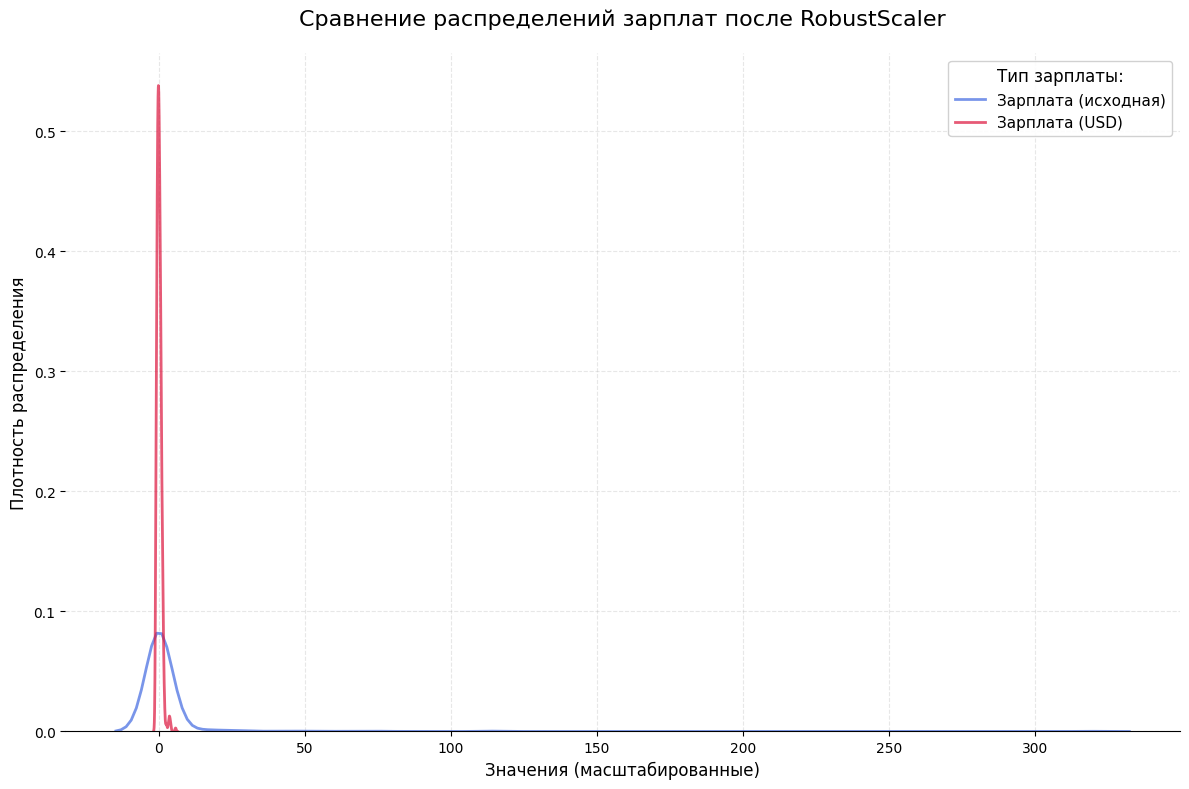

In [13]:
import matplotlib
import matplotlib.pyplot as plt
# для нормализации, стандартизации
from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
df_r = r_scaler.fit_transform(data[['salary', 'salary_in_usd']])
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=['salary', 'salary_in_usd'])
plt.figure(figsize=(12, 8))
# График распределений
ax = sns.kdeplot(df_r['salary'], 
                 color='royalblue',
                 label='Зарплата (исходная)',
                 linewidth=2,
                 alpha=0.7)
ax = sns.kdeplot(df_r['salary_in_usd'], 
                 color='crimson',
                 label='Зарплата (USD)',
                 linewidth=2,
                 alpha=0.7)
plt.title('Сравнение распределений зарплат после RobustScaler', 
          fontsize=16, 
          pad=20)
plt.xlabel('Значения (масштабированные)', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Тип зарплаты:', 
           title_fontsize=12,
           fontsize=11,
           frameon=True,
           framealpha=0.9)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [14]:
data = data.drop(['salary', 'salary_in_usd'], axis=1).join(df_r)
print('Основные статистические харакетриктики столбцов после нормализации')
display(data.describe())
print('Вывод стандартных отклонений после нормализации')
display(data.describe().loc['std'])

Основные статистические харакетриктики столбцов после нормализации


,work_year_2020.0,work_year_2022.0,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,employment_type_CT,employment_type_PT,employment_type_FL,remote_ratio_0.0,...,employee_residence_2,employee_residence_4,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5,salary,salary_in_usd
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,607.00000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,0.118616,0.523888,0.350906,0.461285,0.144975,0.042834,0.008237,0.016474,0.006590,0.209226,...,0.191104,0.248764,0.044481,0.133443,0.15486,0.670511,0.164745,0.836903,2.200001,0.122922
std,0.323603,0.499841,0.477647,0.498910,0.352366,0.202649,0.090459,0.127396,0.080976,0.407091,...,0.393495,0.432654,0.206331,0.340334,0.36207,0.470415,0.371256,0.369759,16.256395,0.813040
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.168421,-1.131047
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,-0.473684,-0.445081
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.526316,0.554919
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,318.789474,5.711094


Вывод стандартных отклонений после нормализации


work_year_2020.0         0.323603
work_year_2022.0         0.499841
experience_level_MI      0.477647
experience_level_SE      0.498910
experience_level_EN      0.352366
experience_level_EX      0.202649
employment_type_CT       0.090459
employment_type_PT       0.127396
employment_type_FL       0.080976
remote_ratio_0.0         0.407091
remote_ratio_50.0        0.369759
remote_ratio_100.0       0.483822
company_size_S           0.343854
company_size_M           0.499035
employee_residence_0     0.226925
employee_residence_1     0.360489
employee_residence_2     0.393495
employee_residence_4     0.432654
company_location_0       0.206331
company_location_1       0.340334
company_location_2       0.362070
company_location_3       0.470415
company_location_4       0.371256
company_location_5       0.369759
salary                  16.256395
salary_in_usd            0.813040
Name: std, dtype: float64

### Вывод по пункту 1

Стандартное отклонение salary_in_usd небольшое, далее будем использовать этот признак для анализа

## 2. Разведывательный анализ данных

### 2.1 Визуальный анализ данных

Нужен для ответа на вопрос:\
Какие факторы влияют на зарплату Data_Scientist'a?

In [15]:
# Критерий фильтрации, который будет использоваться ниже:
# Регулярное выражение помогает найти в тексте нужное сочетание. Поиск осуществляем в наименовании позиции job_title
import re
pattern = r'\b(Data\s*Scientist|Machine\s*Learning|AI|ML)\b'
matches = data['job_title'].str.extractall(pattern, flags=re.IGNORECASE)[0]
print('Значения, найденые регулярным выражением')
matches.value_counts()

Значения, найденые регулярным выражением


0
Data Scientist      159
Machine Learning     62
AI                    7
ML                    6
Name: count, dtype: int64

In [16]:
# Создаем булевую переменную обозначающую, что нужное сочетание найдено
data['is_keyword'] = data['job_title'].str.contains(pattern, flags=re.IGNORECASE, na=False)

C:\Users\Uluana\AppData\Local\Temp\ipykernel_2420\4059093280.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['is_keyword'] = data['job_title'].str.contains(pattern, flags=re.IGNORECASE, na=False)


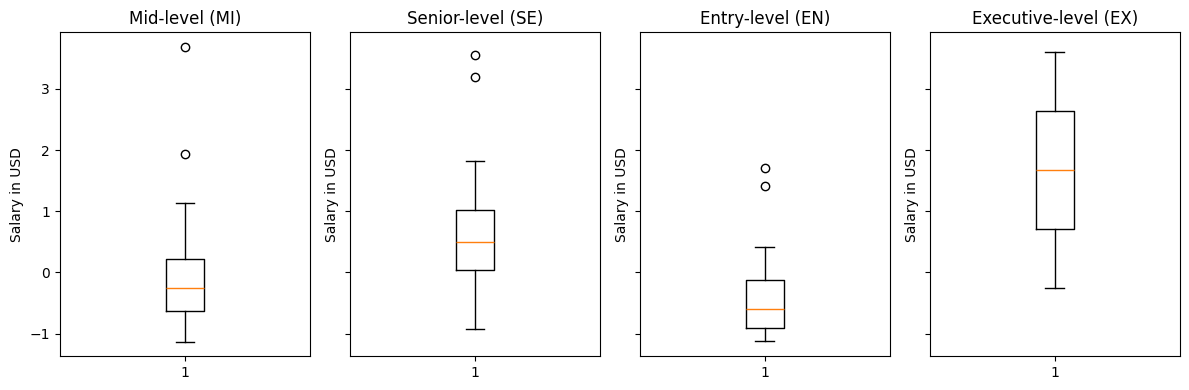

In [17]:
# Построение графиков влияния опыта работы на зарплату в usd
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharey=True)

# Mid-level (MI)
mi_data = data[(data['experience_level_MI'] == 1) & data['is_keyword']]['salary_in_usd']
axs[0].boxplot(mi_data)
axs[0].set_title('Mid-level (MI)')
# Senior-level (SE)
se_data = data[(data['experience_level_SE'] == 1) & data['is_keyword']]['salary_in_usd']
axs[1].boxplot(se_data)
axs[1].set_title('Senior-level (SE)')
# Entry-level (EN)
en_data = data[(data['experience_level_EN'] == 1) & data['is_keyword']]['salary_in_usd']
axs[2].boxplot(en_data)
axs[2].set_title('Entry-level (EN)')
# Executive-level (EX)
ex_data = data[(data['experience_level_EX'] == 1) & data['is_keyword']]['salary_in_usd']
axs[3].boxplot(ex_data)
axs[3].set_title('Executive-level (EX)')

for ax in axs.flat:
    ax.set(ylabel='Salary in USD')

fig.tight_layout()
plt.show()

Зарплаты распределяются по возрастанию: Entry-level (EN) < Mid-level (MI) < Senior-level (SE) < Executive-level (EX). Executive-level (EX) имеет наиболее высокие зарплаты, что соответствует высокой ответственности и опыту. 

Уровни с большим опытом (SE, EX) могут демонстрировать больший разброс зарплат из-за специализации, бонусов, или дополнительных условий. Entry-level (EN) и Mid-level (MI) обычно имеют более узкий разброс, так как зарплаты на этих позициях чаще стандартизированы. 

Наличие выбросов (особенно на уровнях SE и MI) может указывать на значительную вариативность в оплате труда (например, в зависимости от компании, локации, или навыков). Для EN и EX выбросы менее выражены, что говорит о более жестких рамках зарплатных вилок. 

Так как данные нормализованы по RobustScaler, метрики устойчивы к выбросам. Это значит, что медианные значения и межквартильные диапазоны (IQR) точно отражают распределение. Медианы (линии внутри боксов) показывают "типичную" зарплату для каждого уровня. Разница между медианами уровней должна быть статистически значимой.

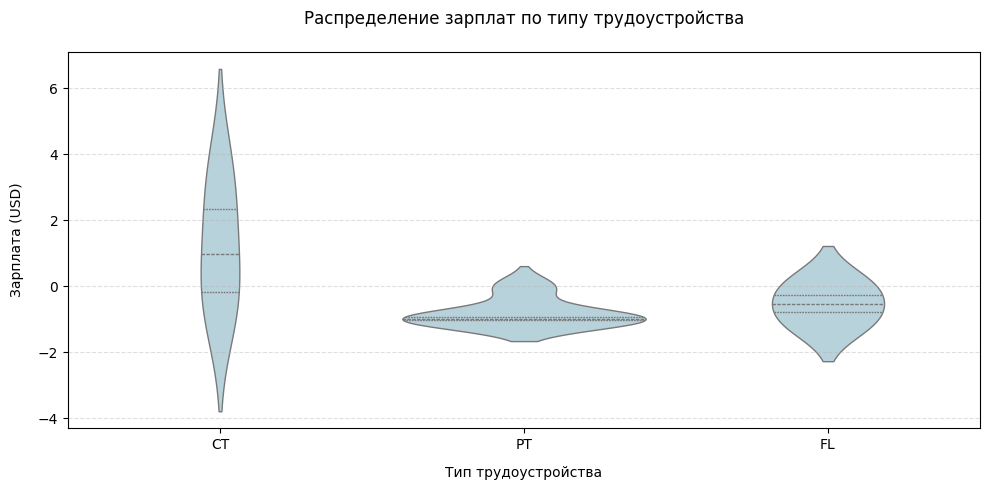

In [18]:
# Построение графиков влияния типа трудоустройства на зарплату в usd
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='employment_type', 
    y='salary_in_usd', 
    data=data[data['is_keyword']],
    order=['CT', 'PT', 'FL'],
    inner='quartile',
    linewidth=1,
    saturation=0.6,
    color='lightblue',
    alpha=1
)

plt.title('Распределение зарплат по типу трудоустройства', pad=20)
plt.xlabel('Тип трудоустройства', labelpad=10)
plt.ylabel('Зарплата (USD)', labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Сравнение толщины: наибольшая у PT (неполный рабочий день) -> больше всего данных этого типа трудоустройства\
Сравнение медиан: самая высокая у CT (CT > FL > PT) -> тип занятости "по контракту" в среднем имеет выше зарплату\
Сравнение длины: наибольшая у CT (особенно в верхнем квантиле 75%) ->
 - много высокооплачиваемых позиций
 - 25% ближе к медиане, чем 75% -> больше высоких зарплат

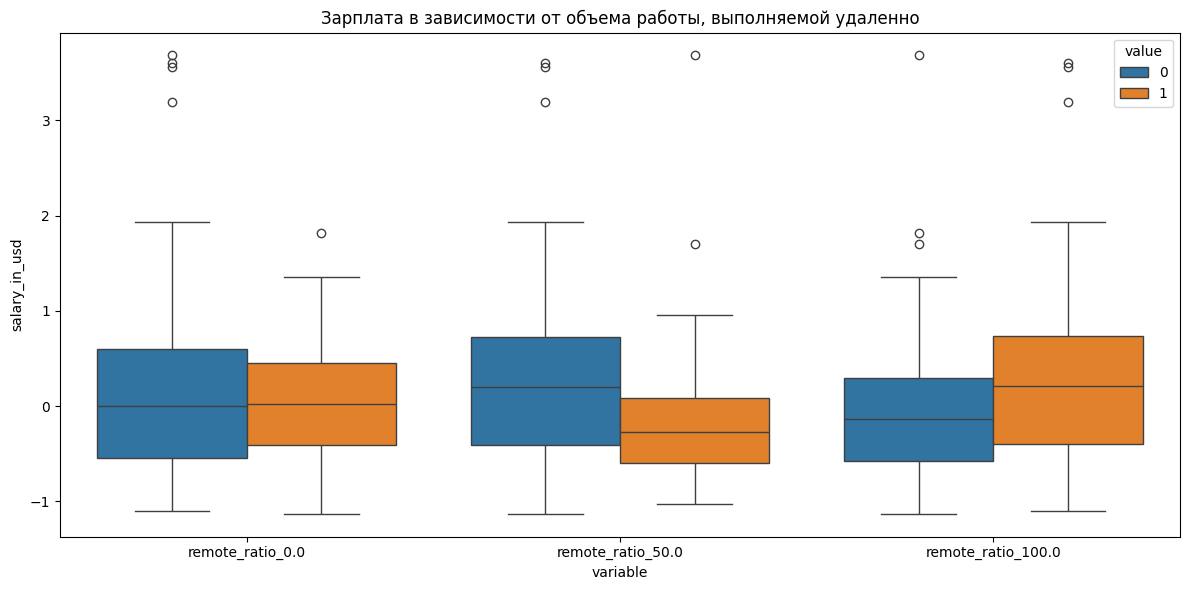

In [19]:
# Функция для фильтрации существующих столбцов
def get_existing_columns(prefix):
    return [col for col in data.columns if col.startswith(prefix)]

# График для remote_ratio (только существующие столбцы)
plt.figure(figsize=(12, 6))
remote_cols = get_existing_columns('remote_ratio_')
if remote_cols:
    sns.boxplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd', 
                            value_vars=remote_cols),
              x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата в зависимости от объема работы, выполняемой удаленно')

plt.tight_layout()
plt.show()

В полность офисном режиме разброс зарплат узкий, медиана ниже, чем в остальных\
При выполнении работы на 50% удаленно разброс зарплат больше, чем в офисе, при это медиана ниже\
При выполнении работы 100% дистанционно медиана выше остальных режимов, разброс зарплат больше офиса, но немного меньше наполовину удаленного режима

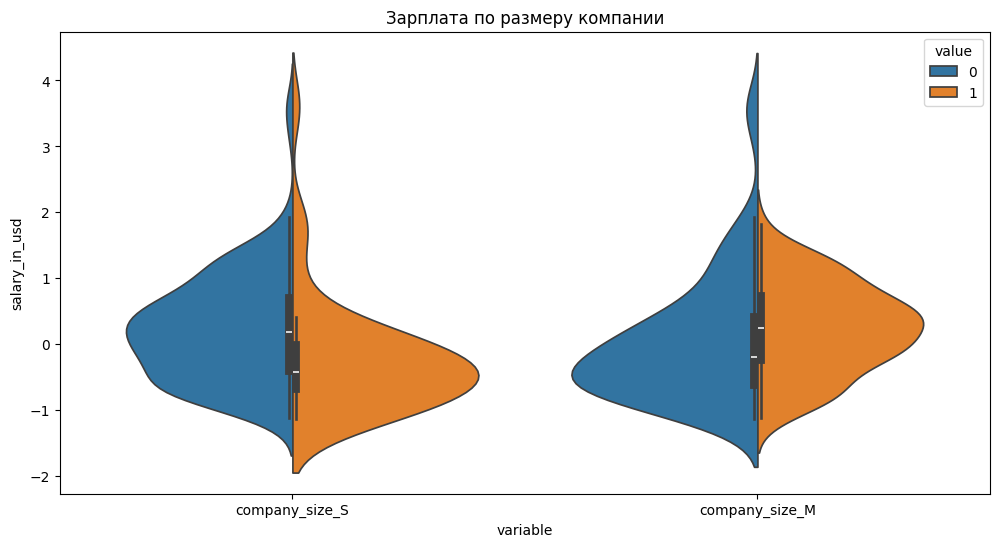

In [20]:
# График для company_size (только существующие столбцы)
plt.figure(figsize=(12, 6))
company_cols = get_existing_columns('company_size_')
if company_cols:
    sns.violinplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                                value_vars=company_cols),
                 x='variable', y='salary_in_usd', hue='value', split=True)
    plt.title('Зарплата по размеру компании')

Компании Middle платят в среднем больше, чем компании Small

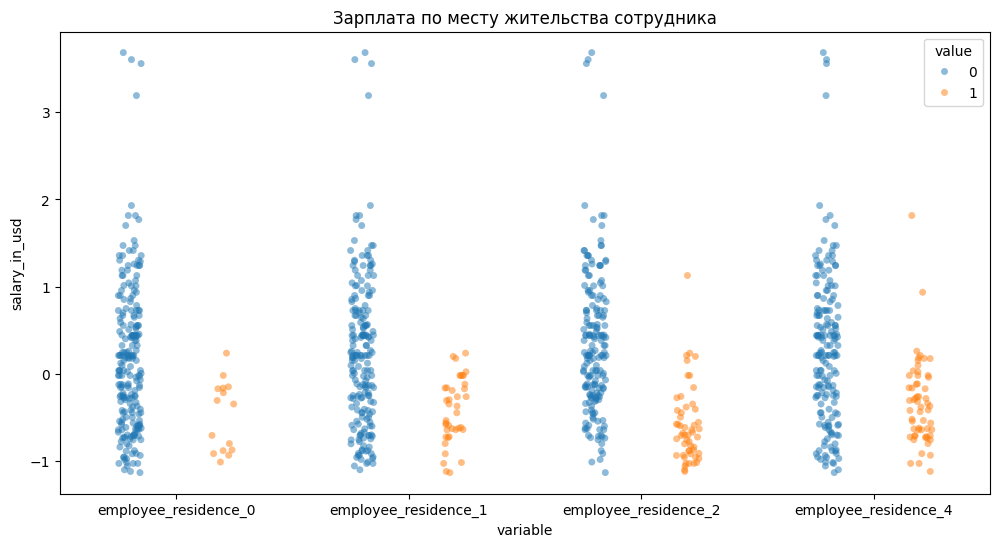

In [21]:
# График для employee_residence (только существующие столбцы)
plt.figure(figsize=(12, 6))
residence_cols = get_existing_columns('employee_residence_')
if residence_cols:
    # Используем strip plot для бинарных переменных
    sns.stripplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                                value_vars=residence_cols),
                 x='variable', y='salary_in_usd', hue='value',
                 dodge=True, jitter=True, alpha=0.5)
    plt.title('Зарплата по месту жительства сотрудника')

В стране проживания сотрудника employee_residence_4 зарплаты наиболее конкруентные по сравнению с остальными странами\
По убыванию номера employee_residence_x конкурентноспособность падает

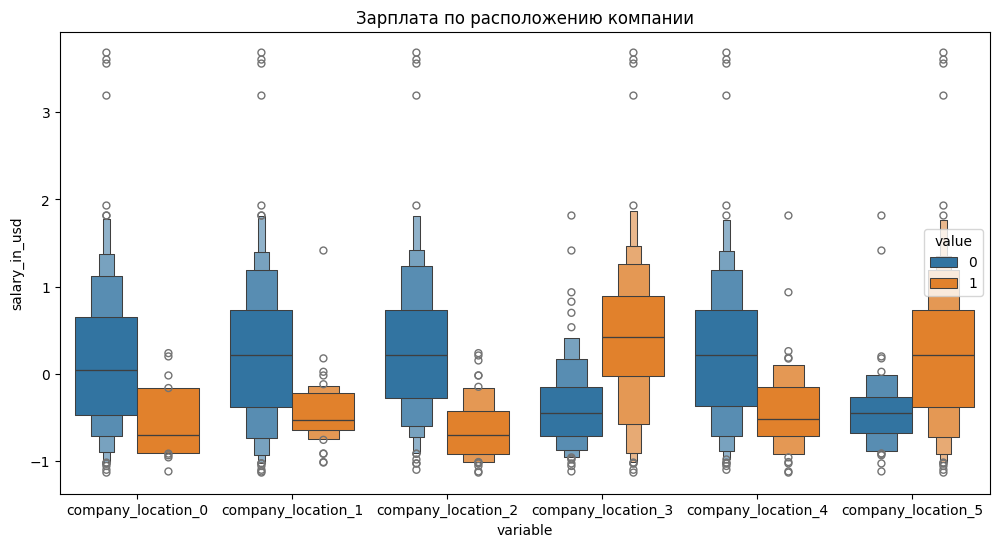

In [22]:
# График для company_location (только существующие столбцы)
plt.figure(figsize=(12, 6))
location_cols = get_existing_columns('company_location_')
if location_cols:
    sns.boxenplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                               value_vars=location_cols),
                x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата по расположению компании')

Выплачиваемые зарплаты в локацииях компний 3,5 в среднем выше, по сравнению с остальными городами\
Наименьший разброс у локаций 0-2

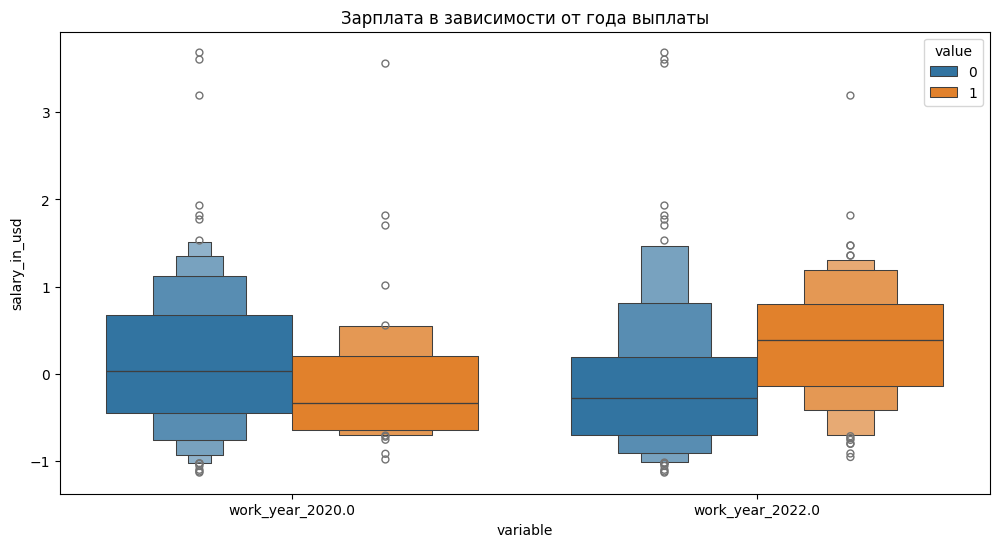

In [23]:
# График для выплаченной ЗП (только существующие столбцы)
plt.figure(figsize=(12, 6))
location_cols = get_existing_columns('work_year_')
if location_cols:
    sns.boxenplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                               value_vars=location_cols),
                x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата в зависимости от года выплаты')

Наблюдается тенденция роста в выплачиваемых зарплатах с увелчением года выплат\
Медиана для 2022 года смещена к 75% квантилю, что говорит о высокой выплачиваемой зарплате в среднем, если распределение нормальное

### Вывод по подпункту 2.1

1. Зарплаты возрастают от EN к EX с увеличением опыта
2. В среднем по контракту для позици Data Scien'тистов зарплата выплачивается выше
3. Сотрудники на полной удаленной работе в средем получают зарплату выше
4. Middle компании в среднем платят больше, чем small
5. В стране employee_residence_4 зарплаты наиболее конкурентные, а с уменьшением номера (employee_residence_x) конкурентоспособность падает
6. Наблюдается тенденция роста зарплат с увеличением года выплат

**Гипотезы к проверке:**

1. Уровень позиции\
H0: Медианные зарплаты не различаются между уровнями позиции (EN = MI = SE = EX).\
H1: Медианные зарплаты возрастают с увеличением уровня позиции (EN < MI < SE < EX).

2. Тип занятости\
H0: Медианные зарплаты не различаются между типами занятости (PT = FL = CT).\
H1: Медианные зарплаты различаются, причём CT > FL > PT.

3. Режим работы\
H0: Медианные зарплаты не различаются между режимами работы (0% = 50% = 100% удалёнки).\
H1: Медианные зарплаты выше при полностью удалённой работе (100% > 50% > 0%).

4. Размер компании\
H0: Медианные зарплаты не различаются между компаниями разного размера (Small = Middle).\
H1: Средние компании платят больше, чем малые (Middle > Small).

5. Локация сотрудника\
H0: Медианные зарплаты не зависят друг от друга между странами проживания сотрудников.\
H1: Медианные зарплаты не зависят друг от друга между странами проживания сотрудников.

6. Локация компании\
H0: Медианные зарплаты не различаются между локациями компаний.\
H1: Локации 3 и 5 платят больше, чем 0-2 (3 ≈ 5 > 0 ≈ 1 ≈ 2).

7. Год выплат\
H0: Медианные зарплаты не различаются между годами.\
H1: Зарплаты растут с увеличением года (2022 > 2021 > 2020).

### 2.2 Статистический анализ данных 

In [24]:
import scipy.stats as stats
# Уровень значимости везде одинаков
alpha = 0.05

-----

H0: Медианные зарплаты не различаются между уровнями позиции (EN = MI = SE = EX).\
H1: Медианные зарплаты возрастают с увеличением уровня позиции (EN < MI < SE < EX).

-----

Чтобы выбрать метод, надо понять, распределен ли признак нормально

In [25]:
# Проверка нормальности распределения зарплат для каждого уровня
levels = ['experience_level_EN', 'experience_level_MI', 'experience_level_SE', 'experience_level_EX']

for level in levels:
    # Правильное условие фильтрации
    level_data = data[(data[level] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
    
    if len(level_data) < 3:
        print(f'{level}: Недостаточно данных для теста (n < 3)')
        continue
    
    stat, p_value = stats.shapiro(level_data)
    print(f'{level}: p-value = {p_value:.3f}')
    
    if p_value <= alpha:
        print(f'Распределение зарплат для {level} НЕ нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {level} нормальное (p > {alpha})')

experience_level_EN: p-value = 0.000
Распределение зарплат для experience_level_EN НЕ нормальное (p ≤ 0.05)
experience_level_MI: p-value = 0.000
Распределение зарплат для experience_level_MI НЕ нормальное (p ≤ 0.05)
experience_level_SE: p-value = 0.001
Распределение зарплат для experience_level_SE НЕ нормальное (p ≤ 0.05)
experience_level_EX: Недостаточно данных для теста (n < 3)


Распределение ненормальное -> непараметрический тест Краскелла-Уоллиса

In [26]:
# Поскольку распределение ненормальное, используем Краскела-Уоллиса
# Собираем зарплаты для каждого уровня опыта (учитывая is_keyword)
salaries_EN = data[(data['experience_level_EN'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_MI = data[(data['experience_level_MI'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_SE = data[(data['experience_level_SE'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_EX = data[(data['experience_level_EX'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Проводим тест Краскела-Уоллиса для зарплат
stat, p_value = stats.kruskal(salaries_EN, salaries_MI, salaries_SE, salaries_EX)

print('\nРезультат теста Краскела-Уоллиса:')
print(f'p-value = {p_value:.3f}')

if p_value <= alpha:
    print(f'p-значение ≤ {alpha}: отвергаем H0')
else:
    print(f'p-значение > {alpha}: нет оснований отвергнуть H0')


Результат теста Краскела-Уоллиса:
p-value = 0.000
p-значение ≤ 0.05: отвергаем H0


Нулевая гипотеза неверна -> влияния опыта работы имеет статистическую значимость

----

H0: Медианные зарплаты не различаются между типами занятости (PT = FL = CT).\
H1: Медианные зарплаты различаются, причём CT > FL > PT.

-----

In [27]:
# Проверка нормальности распределения для каждого типа занятости
employment_types = ['employment_type_CT', 'employment_type_FL', 'employment_type_PT']

for emp_type in employment_types:
    # Правильное условие фильтрации
    emp_data = data[(data[emp_type] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
    
    if len(emp_data) < 3:
        print(f'{emp_type}: Недостаточно данных для теста (n < 3)')
        continue
    
    stat, p_value = stats.shapiro(emp_data)
    print(f'{emp_type}: p-value = {p_value:.3f}')
    
    if p_value <= alpha:
        print(f'Распределение зарплат для {emp_type} НЕ нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {emp_type} нормальное (p > {alpha})')

employment_type_CT: p-value = 0.763
Распределение зарплат для employment_type_CT нормальное (p > 0.05)
employment_type_FL: Недостаточно данных для теста (n < 3)
employment_type_PT: p-value = 0.002
Распределение зарплат для employment_type_PT НЕ нормальное (p ≤ 0.05)


In [28]:
# Собираем данные для анализа
ct_salaries = data[(data['employment_type_CT'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
pt_salaries = data[(data['employment_type_PT'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Для employment_type_FL недостаточно данных (n < 3), поэтому исключаем из анализа
print("Доступные для анализа группы:")
print(f"CT (контракт): n = {len(ct_salaries)}")
print(f"PT (неполный день): n = {len(pt_salaries)}")

# Поскольку для FL недостаточно данных, сравниваем только CT и PT
if len(ct_salaries) >= 3 and len(pt_salaries) >= 3:
    print("\nСравнение CT и PT:")
    
    # CT - нормальное распределение (p=0.763), PT - ненормальное (p=0.002)
    # Используем непараметрический тест Манна-Уитни
    _, p_value = stats.mannwhitneyu(ct_salaries, pt_salaries, alternative='greater')
    print(f"U-критерий Манна-Уитни: p-value = {p_value:.3f}")
    
    if p_value <= alpha:
        print(f"CT зарплаты значимо выше PT (p ≤ {alpha})")
        print("Статистически значимые различия между контрактными и неполными позициями")
    else:
        print(f"Нет доказательств, что CT зарплаты выше PT (p > {alpha})")
else:
    print("\nНедостаточно данных для сравнения CT и PT")

Доступные для анализа группы:
CT (контракт): n = 4
PT (неполный день): n = 5

Сравнение CT и PT:
U-критерий Манна-Уитни: p-value = 0.018
CT зарплаты значимо выше PT (p ≤ 0.05)
Статистически значимые различия между контрактными и неполными позициями


----

H0: Медианные зарплаты не различаются между режимами работы (0% = 50% = 100% удалёнки).\
H1: Медианные зарплаты выше при полностью удалённой работе (100% > 50% > 0%).

-----

In [29]:
# Проверка нормальности распределения для каждого режима работы
remote_levels = ['remote_ratio_0.0', 'remote_ratio_50.0', 'remote_ratio_100.0']

# Словарь для хранения данных по каждой группе
salaries_dict = {}

for level in remote_levels:
    # Правильное условие фильтрации
    level_data = data[(data[level] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
    salaries_dict[level] = level_data
    
    if len(level_data) < 3:
        print(f'{level}: Недостаточно данных для теста (n = {len(level_data)})')
        continue
    
    stat, p_value = stats.shapiro(level_data)
    print(f'{level}: p-value = {p_value:.3f}')
    
    if p_value <= alpha:
        print(f'Распределение зарплат для {level} НЕ нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {level} нормальное (p > {alpha})')

remote_ratio_0.0: p-value = 0.475
Распределение зарплат для remote_ratio_0.0 нормальное (p > 0.05)
remote_ratio_50.0: p-value = 0.000
Распределение зарплат для remote_ratio_50.0 НЕ нормальное (p ≤ 0.05)
remote_ratio_100.0: p-value = 0.000
Распределение зарплат для remote_ratio_100.0 НЕ нормальное (p ≤ 0.05)


Распределение ненормальное -> непараметрический тест Краскелла-Уоллиса

In [30]:
# Подготовка данных
data_0 = data[(data['remote_ratio_0.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
data_50 = data[(data['remote_ratio_50.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
data_100 = data[(data['remote_ratio_100.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Поскольку 2 из 3 групп имеют ненормальное распределение, используем Краскела-Уоллиса
stat, p_kruskal = stats.kruskal(data_0, data_50, data_100)
print(f"Критерий Краскела-Уоллиса: p-value = {p_kruskal:.4f}")

if p_kruskal <= alpha:
    print(f"Есть статистически значимые различия между группами (p ≤ {alpha})")
    
    # Post-hoc анализ с поправкой Бонферрони
    print("\nPost-hoc анализ (Манна-Уитни):")
    
    # Все возможные пары сравнений
    comparisons = [('0%', data_0, '50%', data_50),
                   ('0%', data_0, '100%', data_100),
                   ('50%', data_50, '100%', data_100)]
    
    for name1, group1, name2, group2 in comparisons:
        _, p_mw = stats.mannwhitneyu(group1, group2, alternative='less')
        
        print(f"{name1} vs {name2}: p = {p_mw:.4f}", end=" ")
        if p_mw <= alpha:
            print(f"Различия значимы (медиана {name2} > {name1})")
        else:
            print("Различия не значимы")
else:
    print(f"Нет значимых различий между группами (p > {alpha})")

Критерий Краскела-Уоллиса: p-value = 0.0022
Есть статистически значимые различия между группами (p ≤ 0.05)

Post-hoc анализ (Манна-Уитни):
0% vs 50%: p = 0.9919 Различия не значимы
0% vs 100%: p = 0.1526 Различия не значимы
50% vs 100%: p = 0.0003 Различия значимы (медиана 100% > 50%)


-----

H0: Медианные зарплаты не различаются между компаниями разного размера (Small = Middle).\
H1: Медианные зарплаты различаются между компаниями разного размера (Small = Middle).

------

In [31]:
import scipy.stats as stats
# Критерий Хи-квадрат

In [32]:
# Создаем категориальную переменную размера компании
data['company_size'] = 'Small'
data.loc[data['company_size_M'] == 1, 'company_size'] = 'Middle'

# Фильтруем только нужные данные
filtered_data = data[data['is_keyword'] == 1]

# Создаем таблицу сопряжённости между размером компании и категоризированными зарплатами
# Категоризируем зарплаты на 3 группы (низкие, средние, высокие)
filtered_data['salary_category'] = pd.qcut(filtered_data['salary_in_usd'], 
                                         q=3, 
                                         labels=['low', 'medium', 'high'])

# Строим таблицу сопряжённости
contingency_table = pd.crosstab(filtered_data['company_size'], 
                               filtered_data['salary_category'])

print("Таблица сопряжённости:")
print(contingency_table)

# Проводим тест хи-квадрат
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print('\nРезультаты теста хи-квадрат:')
print(f'p-value = {p:.4f}')

# Интерпретация
if p <= alpha:
    print(f'p ≤ {alpha}: Отвергаем H0. Есть связь между размером компании и распределением зарплат.')
else:
    print(f'p > {alpha}: Нет оснований отвергнуть H0. Связи не обнаружено.')

Таблица сопряжённости:
salary_category  low  medium  high
company_size                      
Middle            22      39    47
Small             56      39    31

Результаты теста хи-квадрат:
p-value = 0.0002
p ≤ 0.05: Отвергаем H0. Есть связь между размером компании и распределением зарплат.


C:\Users\Uluana\AppData\Local\Temp\ipykernel_2420\2793359255.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['salary_category'] = pd.qcut(filtered_data['salary_in_usd'],


----

H0: Медианные зарплаты одинаковы для всех стран компаний.\
H1: Медианные зарплаты различаются хотя бы для одной пары стран.

-----

In [33]:
# Проверка нормальности распределения
locations = ['company_location_0', 'company_location_1', 'company_location_2', 
             'company_location_3', 'company_location_4', 'company_location_5']

# Словарь для хранения данных
salaries_by_location = {}

for loc in locations:
    # Фильтрация
    loc_data = data[(data[loc] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
    salaries_by_location[loc] = loc_data
    
    if len(loc_data) < 3:
        print(f'{loc}: Недостаточно данных (n = {len(loc_data)})')
        continue
        
    stat, p_value = stats.shapiro(loc_data)
    print(f'{loc}: p-value = {p_value:.3f}', end=' ')
    print('не нормальное' if p_value <= alpha else 'нормальное')

company_location_0: p-value = 0.100 нормальное
company_location_1: p-value = 0.000 не нормальное
company_location_2: p-value = 0.006 не нормальное
company_location_3: p-value = 0.000 не нормальное
company_location_4: p-value = 0.000 не нормальное
company_location_5: p-value = 0.000 не нормальное


In [34]:
# Собираем данные по зарплатам для каждой страны
salaries_0 = data[(data['company_location_0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_1 = data[(data['company_location_1'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_2 = data[(data['company_location_2'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_3 = data[(data['company_location_3'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_4 = data[(data['company_location_4'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_5 = data[(data['company_location_5'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Проверяем, что в каждой группе достаточно данных (минимум 3 наблюдения)
valid_groups = []
for i, salaries in enumerate([salaries_0, salaries_1, salaries_2, salaries_3, salaries_4, salaries_5]):
    if len(salaries) >= 3:
        valid_groups.append(salaries)
        print(f'company_location_{i}: n = {len(salaries)}')
    else:
        print(f'company_location_{i}: недостаточно данных (n = {len(salaries)})')

# Проводим тест Краскела-Уоллиса только если есть хотя бы 2 группы с достаточными данными
if len(valid_groups) >= 2:
    h_stat, p_value = stats.kruskal(*valid_groups)
    print(f'\nКритерий Краскела-Уоллиса: p-value = {p_value:.4f}')
    
    if p_value <= alpha:
        print(f'Отвергаем H0 (p ≤ {alpha}): медианные зарплаты различаются между странами')
    else:
        print(f'Не отвергаем H0 (p > {alpha}): нет доказательств различий')
else:
    print('\nНедостаточно данных для проведения теста (нужно ≥2 группы с n ≥ 3)')

company_location_0: n = 14
company_location_1: n = 37
company_location_2: n = 42
company_location_3: n = 146
company_location_4: n = 41
company_location_5: n = 193

Критерий Краскела-Уоллиса: p-value = 0.0000
Отвергаем H0 (p ≤ 0.05): медианные зарплаты различаются между странами


----------

H0: Медианные зарплаты не различаются друг от друга между странами проживания сотрудников.\
H1: Медианные зарплаты различаются друг от друга между странами проживания сотрудников.

-------------------

In [35]:
levels = ['employee_residence_0', 'employee_residence_1', 'employee_residence_2', 'employee_residence_4']
groups = []

for level in levels:
    # Выбираем зарплаты для текущего уровня
    level_data = data[(data[level] == 1) & data['is_keyword']]['salary_in_usd'].dropna()
    groups.append(level_data)
    
    # Проверяем размер выборки
    if len(level_data) < 3:
        print(f'{level}: Недостаточно данных для теста (n < 3)')
        continue
    
    # Проводим тест Шапиро-Уилка
    stat, p_value = stats.shapiro(level_data)
    print(f'{level}: p-value = {p_value:.3f}')
    
    # Интерпретация
    if p_value <= alpha:
        print(f'Распределение зарплат для {level} не нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {level} нормальное (p > {alpha})')

employee_residence_0: p-value = 0.087
Распределение зарплат для employee_residence_0 нормальное (p > 0.05)
employee_residence_1: p-value = 0.341
Распределение зарплат для employee_residence_1 нормальное (p > 0.05)
employee_residence_2: p-value = 0.000
Распределение зарплат для employee_residence_2 не нормальное (p ≤ 0.05)
employee_residence_4: p-value = 0.000
Распределение зарплат для employee_residence_4 не нормальное (p ≤ 0.05)


In [36]:
from scipy.stats import levene

# Фильтрация данных для Data Science
group0 = data[(data['employee_residence_0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
group1 = data[(data['employee_residence_1'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Проверка равенства дисперсий
levene_stat, levene_p = levene(group0, group1)
print(f"Тест Левена: p = {levene_p:.4f}")

if levene_p > alpha:
    print("Дисперсии равны (используем t-тест с equal_var=True)")
    equal_var = True
else:
    print("Дисперсии не равны (используем t-тест с equal_var=False)")
    equal_var = False

Тест Левена: p = 0.4773
Дисперсии равны (используем t-тест с equal_var=True)


In [37]:
from scipy.stats import ttest_ind

# Проверка минимального размера выборки
if len(group0) > 2 and len(group1) > 2:
    t_stat, p_value = ttest_ind(group0, group1, equal_var=equal_var)
    print(f"\nt-тест: p = {p_value:.4f}")
    print("Различия значимы" if p_value <= alpha else "Различий нет")
else:
    print("Недостаточно данных для t-теста (n < 3 в одной из групп)")


t-тест: p = 0.6462
Различий нет


In [38]:
from scipy.stats import kruskal

group2 = data[(data['employee_residence_2'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
group4 = data[(data['employee_residence_4'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

if len(group2) > 2 and len(group4) > 2:
    h_stat, p_value = kruskal(group2, group4)
    print(f"\nКрускал-Уоллис: p = {p_value:.4f}")
    print("Различия значимы" if p_value <= 0.05 else "Различий нет")
else:
    print("Недостаточно данных для теста (n < 3 в одной из групп)")


Крускал-Уоллис: p = 0.0008
Различия значимы


In [39]:
groups = [
    data[(data['employee_residence_0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna(),
    data[(data['employee_residence_1'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna(),
    data[(data['employee_residence_2'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna(),
    data[(data['employee_residence_4'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
]

if all(len(g) > 2 for g in groups):
    h_stat, p_value = kruskal(*groups)
    print(f"\nКрускал-Уоллис (все группы): p = {p_value:.4f}")
    print("Есть значимые различия" if p_value <= alpha else "Нет различий")
else:
    print("Недостаточно данных в одной из групп (n < 3)")


Крускал-Уоллис (все группы): p = 0.0067
Есть значимые различия


для резиденций 0,1 различия в зарплате статистически незначимы\
Для резиденций 2,4 значимы\
При этом различия между ними в зарплатах попарно статистически значимы 

-----

H0: Медианные зарплаты не различаются между годами.\
H1: Медианные зарплаты различаются между годами.

------

Так как данные независимы -> тест Манна-Уитни (U-тест)

In [ ]:
# Выборка зарплат для Data Science по годам
salaries_2020 = data[(data['work_year_2020.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_2022 = data[(data['work_year_2022.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Проверка минимального размера выборки
if len(salaries_2020) >= 3 and len(salaries_2022) >= 3:
    # U-тест (независимые выборки)
    stat, p_value = stats.mannwhitneyu(salaries_2020, salaries_2022, alternative='two-sided')
    print(f"U-тест: p-value = {p_value:.4f}")
    if p_value <= alpha:
        print("Отвергаем H0: медианные зарплаты различаются")
    else:
        print("Нет статистически значимых различий")
else:
    print("Недостаточно данных для теста (n < 3)")

U-тест: p-value = 0.0004
Отвергаем H0: медианные зарплаты различаются


### Вывод по подпункту 2.2

На уровень зарплаты влияет опыт работы, тип занятости, режим работы, размер компании, локация компании и сотрудника, год выплат

### Вывод по пунтку 2

1. Чем выше уровень позиции, тем выше зарплата.
2. Контрактные позиции оплачиваются выше, чем неполная занятость.
3. Полностью удалённые сотрудники получают больше, чем офисные.
4. Middle-компании платят в среднем больше, чем Small.
5. Зарплата сотрудников в разных регионах отличается.
6. Зарплаты росли с 2020 по 2022 год.

## 3. Ответы на вопросы

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

H0: Зарплата 2022 г <= 2020 г\
H1: Зарплата 2022 г > 2020 г

In [50]:
from scipy import stats
from scipy.stats import mannwhitneyu

years = ['work_year_2020.0', 'work_year_2022.0']

for year in years:
    years_data = data[(data[year] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
    
    if len(years_data) < 3:
        print(f'{year}: Недостаточно данных для теста (n = {len(years_data)})')
        continue
    
    stat, p_value = stats.shapiro(years_data)
    print(f'{year}: p-value = {p_value:.3f}')
    
    if p_value <= alpha:
        print(f'Распределение зарплат для {year} НЕ нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {year} нормальное (p > {alpha})')

work_year_2020.0: p-value = 0.000
Распределение зарплат для work_year_2020.0 НЕ нормальное (p ≤ 0.05)
work_year_2022.0: p-value = 0.010
Распределение зарплат для work_year_2022.0 НЕ нормальное (p ≤ 0.05)


In [ ]:
# Подготовка данных для теста
salaries_2020 = data[(data['work_year_2020.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()
salaries_2022 = data[(data['work_year_2022.0'] == 1) & (data['is_keyword'])]['salary_in_usd'].dropna()

# Проверка размера выборок
if len(salaries_2020) < 3 or len(salaries_2022) < 3:
    print("Одна из выборок слишком мала для теста")
else:
    # U-критерий Манна-Уитни с односторонней альтернативой
    stat, p_value = stats.mannwhitneyu(salaries_2022, salaries_2020, 
                                alternative='greater',  # Проверяем H1: 2022 > 2020
                                method="exact")
    
    print(f"\nU-тест Манна-Уитни:")
    print(f"p-value = {p_value:.4f}")
    
    if p_value <= alpha:
        print(f"Отвергаем H0: зарплаты в 2022 году значимо выше (p ≤ {alpha})")
    else:
        print(f"Нет оснований отвергать H0: зарплаты не выросли (p > {alpha})")


U-тест Манна-Уитни:
Статистика = 2674.500, p-value = 0.0001
Отвергаем H0: зарплаты в 2022 году значимо выше (p ≤ 0.05)


Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

H0: Зарплаты Data Scientist и Data Engineer равны в 2022 г\
H1: Зарплаты Dara Scientist и Data Engineer не равны в 2022 г

In [62]:
# Создаем фильтры для 2022 года
data_2022 = data[data['work_year_2022.0'] == 1]
# Выделяем зарплаты для каждой профессии
salaries_eng = data_2022[data_2022['job_title'] == 'Data Engineer']['salary_in_usd'].dropna()
salaries_sci = data_2022[data_2022['is_keyword']]['salary_in_usd'].dropna()

In [63]:
# Проверка нормальности распределений
print("Проверка нормальности распределений:")
for name, sample in [('Data Engineer', salaries_eng), ('Data Scientist', salaries_sci)]:
    if len(sample) < 3:
        print(f"{name}: недостаточно данных (n < 3)")
        continue
    stat, p = stats.shapiro(sample)
    print(f"{name}: p-value = {p:.3f} ({'не нормальное' if p <= alpha else 'нормальное'})")

Проверка нормальности распределений:
Data Engineer: p-value = 0.010 (не нормальное)
Data Scientist: p-value = 0.010 (не нормальное)


In [64]:
# U-тест Манна-Уитни для независимых выборок
stat, p_value = mannwhitneyu(salaries_eng, salaries_sci, alternative='two-sided')
    
print(f"\nРезультаты U-теста Манна-Уитни:")
print(f"Статистика = {stat:.1f}, p-value = {p_value:.4f}")
    
if p_value <= alpha:
    print(f"Отвергаем H0: зарплаты различаются (p ≤ {alpha})")
    # Дополнительно: какая группа имеет более высокие зарплаты
    if salaries_eng.median() > salaries_sci.median():
        print("Data Engineer имеют более высокие зарплаты")
    else:
        print("Data Scientist имеют более высокие зарплаты")
else:
    print(f"Нет оснований отвергать H0: зарплаты не различаются (p > {alpha})")


Результаты U-теста Манна-Уитни:
Статистика = 4563.0, p-value = 0.3046
Нет оснований отвергать H0: зарплаты не различаются (p > 0.05)


Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

H0: Зарплаты специалистов Data Scientist в компаниях различных размеров не отличаются\
H1: Зарплаты специалистов Data Scientist в компаниях различных размеров отличаются

In [65]:
data_s = data[data['company_size_S'] == 1]
data_m = data[data['company_size_M'] == 1]
# Выделяем зарплаты для размеров компаний
size_s = data_s[data_s['is_keyword'] ]['salary_in_usd'].dropna()
size_m = data_m[data_m['is_keyword']]['salary_in_usd'].dropna()

In [66]:
# Проверка нормальности распределений
print("Проверка нормальности распределений:")
for size, sample in [('M', size_m), ('S', size_s)]:
    if len(sample) < 3:
        print(f"{size}: недостаточно данных (n < 3)")
        continue
    stat, p = stats.shapiro(sample)
    print(f"{size}: p-value = {p:.3f} ({'не нормальное' if p <= alpha else 'нормальное'})")

Проверка нормальности распределений:
M: p-value = 0.210 (нормальное)
S: p-value = 0.000 (не нормальное)


In [ ]:
from scipy.stats import mannwhitneyu
# U-тест Манна-Уитни (двусторонний)
_, p_value = mannwhitneyu(size_m, size_s, alternative='two-sided')
# Вывод результатов
print(f"p-value = {p_value:.2f}")
if p_value < alpha:
    print(f'Зарплаты различаются в зависимости от размера {p_value:.2f} < {alpha}')
else:
    print(f'Зарплаты не различаются в зависимости от размера {p_value:.2f} > {alpha}')

p-value = 0.00
Зарплаты различаются в зависимоси от размера 0.00 < 0.05


Тогда нужно сделать дополнительную проверку больше или меньше:\
H0: ЗП в s-компаниях >= m-компаний\
H1: ЗП в s-компаниях < m-компаний

In [74]:
from scipy.stats import mannwhitneyu
# U-тест Манна-Уитни (двусторонний)
_, p_value = mannwhitneyu(size_s, size_m, alternative='less')
# Вывод результатов
print(f"p-value = {p_value:.2f}")
if p_value < alpha:
    print(f'Отвергаем H0: зарплаты в S компаниях ниже M {p_value:.2f} < {alpha}')
else:
    print(f'Оснований отвергать H0 нет {p_value:.2f} > {alpha}')

p-value = 0.00
Отвергаем H0: зарплаты в S компаниях ниже M 0.00 < 0.05


Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

H0: Связь между наличием должностей Data Scientist и Data Engineer и размером компании есть\
H1: Связи между наличием должностей Data Scientist и Data Engineer и размером компании нет

In [84]:
# Критерий хи-квадрат
from scipy.stats import chi2_contingency
# Создаем признак для должностей (Data Scientist или Data Engineer)
data['target_role'] = ['Data Engineer' if x else 'Data Scientist' 
                      for x in (data['job_title'] == 'Data Engineer') | data['is_keyword']]
# Преобразуем one-hot кодировку в категориальный признак
data['company_size'] = ['S' if s == 1 else 'M' 
                       for s in data['company_size_S']]  # 1=S, 0=M (предполагая, что есть только S и M)
# Строим таблицу сопряженности
table = pd.crosstab(data['target_role'], data['company_size'])
# Проводим тест
_, p, _, _ = stats.chi2_contingency(table)
print('p-value = {:.3f}'.format(p))
# Интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.913
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Выводы по пункту 3

1. Зарплаты в 2022 г > 2020 г
2. Медианные зарплаты Data Scentist'ов и Data Engineer'ов не отличаются
3. Зарплаты различаются в зависимоси от размера компании: медианные зарплаты в S компаниях ниже M
4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании есть

## 4. Дополнительное исследование

### 4.1 Визуальный анализ

### Выводы по подпункту 4.1

### 4.2 Статистический анализ

### Выводы по подпункту 4.2

### Вывод по пунтку 4